In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

# -----------------------------------
# Load your data
# -----------------------------------
df = pd.read_csv('merged_stock_with_fama_french.csv')
df['Date'] = pd.to_datetime(df['Date'])

# -----------------------------------
# Clean the Return column: remove % and convert to float
# -----------------------------------
df['Return'] = df['Return'].str.replace('%', '', regex=False)  # Remove percentage sign
df['Return'] = df['Return'].str.replace(',', '.', regex=False)  # Replace comma with dot
df['Return'] = pd.to_numeric(df['Return'], errors='coerce')  # Convert to float safely

# -----------------------------------
# Function to check stationarity
# -----------------------------------
def check_stationarity(series):
    result = adfuller(series.dropna())
    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]

    is_stationary = p_value < 0.05

    return {
        'ADF Statistic': adf_stat,
        'p-value': p_value,
        'Stationary': is_stationary,
        'Critical Values': critical_values
    }

# -----------------------------------
# Loop over companies and store results
# -----------------------------------
companies = df['Company'].unique()

stationarity_results = []

for company in tqdm(companies, desc="Checking stationarity", ncols=100):
    company_df = df[df['Company'] == company].sort_values('Date')

    if company_df['Return'].isnull().sum() > 0:
        company_df = company_df.dropna(subset=['Return'])

    result = check_stationarity(company_df['Return'])
    stationarity_results.append({
        'Company': company,
        'ADF Statistic': result['ADF Statistic'],
        'p-value': result['p-value'],
        'Stationary': result['Stationary']
    })

# -----------------------------------
# Save stationarity results
# -----------------------------------
stationarity_df = pd.DataFrame(stationarity_results)
stationarity_df.to_csv('stationarity_test_results.csv', index=False)

print("✅ Stationarity testing complete. Results saved to 'stationarity_test_results.csv'.")

# -----------------------------------
# (Optional) Quick Summary
# -----------------------------------
num_stationary = stationarity_df['Stationary'].sum()
print(f"\nSummary: {num_stationary} out of {len(companies)} companies are stationary.")


Checking stationarity: 100%|████████████████████████████████████████| 45/45 [00:03<00:00, 12.80it/s]


✅ Stationarity testing complete. Results saved to 'stationarity_test_results.csv'.

Summary: 45 out of 45 companies are stationary.


Calculating ACF(1) and PACF(1):   0%|          | 0/45 [00:00<?, ?it/s]

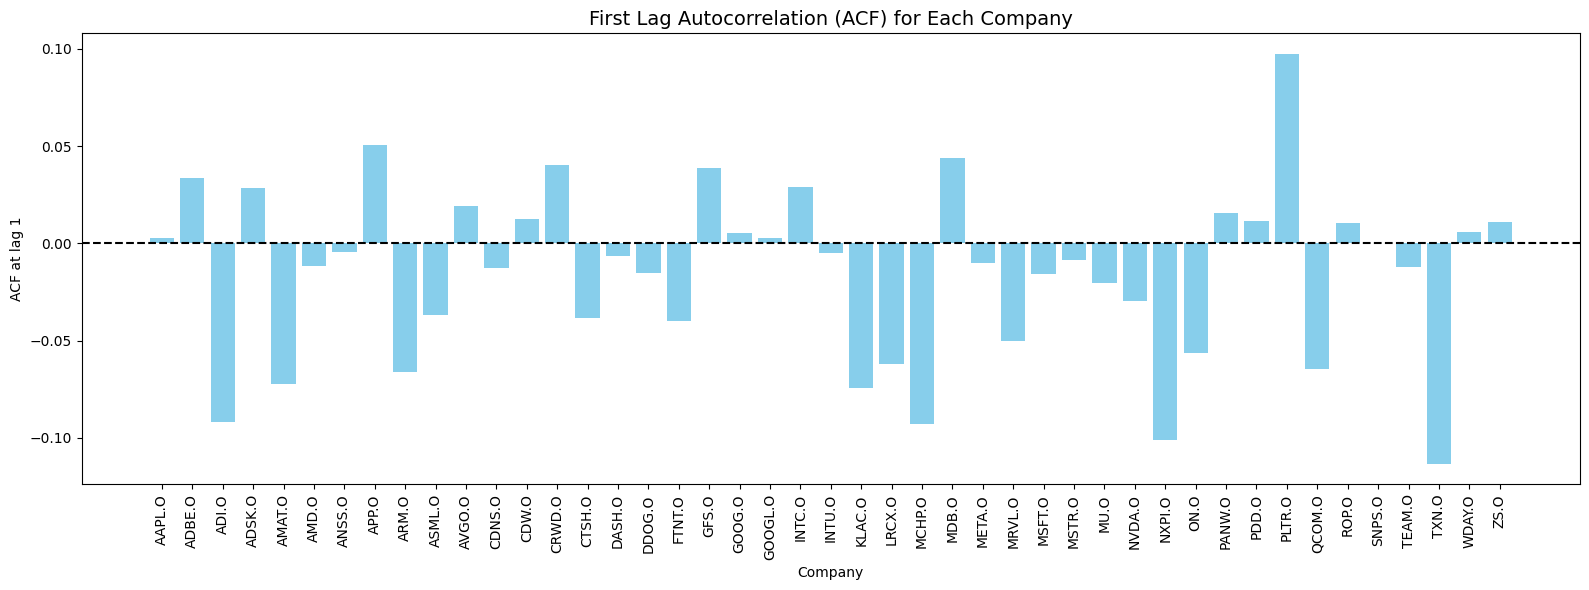

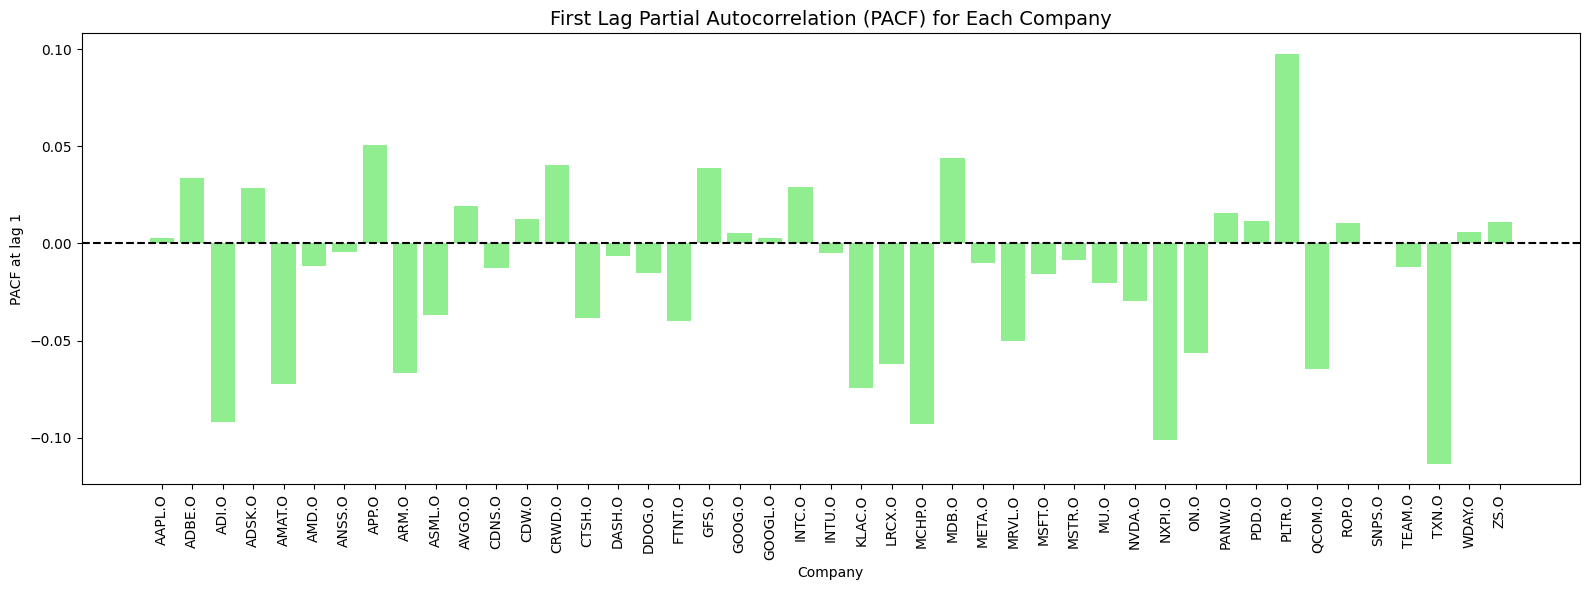

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from tqdm.notebook import tqdm

# Load your dataset
df = pd.read_csv('merged_stock_with_fama_french.csv')

# Clean 'Return' column
df['Return'] = df['Return'].str.replace(',', '.').str.replace('%', '')
df['Return'] = pd.to_numeric(df['Return'], errors='coerce')

companies = df['Company'].unique()

acf_first_lag = []
pacf_first_lag = []

for company in tqdm(companies, desc="Calculating ACF(1) and PACF(1)"):
    company_returns = df[df['Company'] == company]['Return'].dropna()

    if len(company_returns) < 10:
        acf_first_lag.append(None)
        pacf_first_lag.append(None)
        continue

    acf_values = acf(company_returns, nlags=1, fft=False)
    pacf_values = pacf(company_returns, nlags=1)

    acf_first_lag.append(acf_values[1])   # lag-1 autocorrelation
    pacf_first_lag.append(pacf_values[1]) # lag-1 partial autocorrelation

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Company': companies,
    'ACF_lag1': acf_first_lag,
    'PACF_lag1': pacf_first_lag
})

# ----------------- Plot ACF(1) ----------------
plt.figure(figsize=(16, 6))
plt.bar(summary_df['Company'], summary_df['ACF_lag1'], color='skyblue')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('First Lag Autocorrelation (ACF) for Each Company', fontsize=14)
plt.xlabel('Company')
plt.ylabel('ACF at lag 1')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ----------------- Plot PACF(1) ----------------
plt.figure(figsize=(16, 6))
plt.bar(summary_df['Company'], summary_df['PACF_lag1'], color='lightgreen')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('First Lag Partial Autocorrelation (PACF) for Each Company', fontsize=14)
plt.xlabel('Company')
plt.ylabel('PACF at lag 1')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




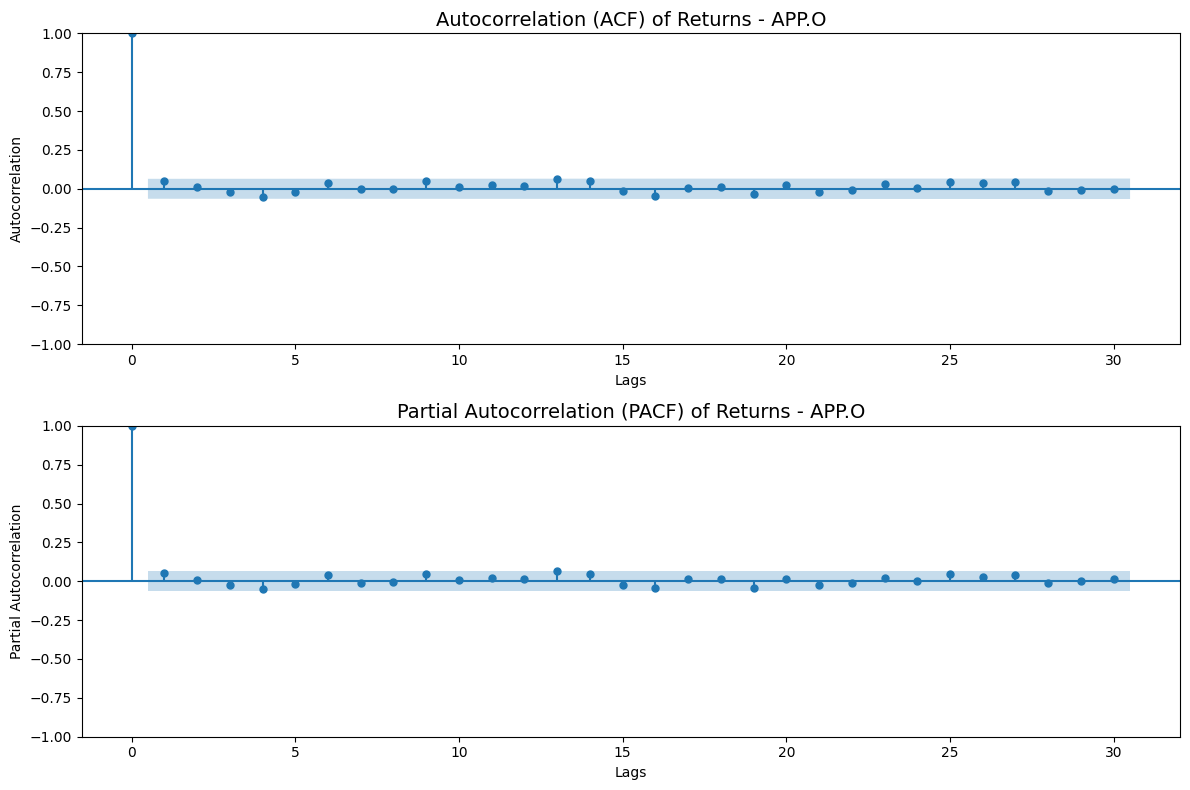

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ----------------------------
# Load and clean your dataset
# ----------------------------
df = pd.read_csv('merged_stock_with_fama_french.csv')

# Fix 'Return' column
df['Return'] = df['Return'].str.replace(',', '.').str.replace('%', '')
df['Return'] = pd.to_numeric(df['Return'], errors='coerce')

# ----------------------------
# Pick one example company
# ----------------------------
example_company = 'APP.O'  # <-- Change this to any company you want

# Filter the data
company_df = df[df['Company'] == example_company].dropna(subset=['Return']).sort_values('Date')

# ----------------------------
# Plot ACF and PACF
# ----------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF
plot_acf(company_df['Return'], lags=30, ax=axes[0])
axes[0].set_title(f'Autocorrelation (ACF) of Returns - {example_company}', fontsize=14)
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Autocorrelation')

# PACF
plot_pacf(company_df['Return'], lags=30, ax=axes[1], method='ywm')
axes[1].set_title(f'Partial Autocorrelation (PACF) of Returns - {example_company}', fontsize=14)
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings('ignore')

# Load your data
df = pd.read_csv('merged_stock_with_fama_french.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Proper cleaning
df['Return'] = df['Return'].astype(str)
df['Return'] = df['Return'].str.replace('%', '', regex=False)
df['Return'] = df['Return'].str.replace(',', '.', regex=False)
df['Return'] = df['Return'].str.strip()

# 🔥 HARD-CODE removal of the bad row with '#VALUE!'
df = df[df['Return'] != '#VALUE!']

# Now convert safely
df['Return'] = df['Return'].astype(float)

# Set date as index
df.set_index('Date', inplace=True)

# Prepare to store results
all_predictions = []

# Get list of companies
companies = df['Company'].unique()

# Loop through each company
for company in tqdm(companies, desc="Training rolling ARIMA models"):
    company_df = df[df['Company'] == company].copy()

    if len(company_df) < 50:
        continue

    returns = company_df['Return']

    split_idx = int(len(returns) * 0.8)
    train, test = returns.iloc[:split_idx], returns.iloc[split_idx:]

    history = train.tolist()
    preds = []

    for true_val in test:
        model = ARIMA(history, order=(1, 0, 1))
        model_fit = model.fit()

        forecast = model_fit.forecast()[0]
        preds.append(forecast)

        history.append(true_val)

    temp_df = pd.DataFrame({
        'Date': test.index,
        'Company': company,
        'Predicted_Return': preds,
        'Actual_Return': test.values
    })

    all_predictions.append(temp_df)

# Combine all predictions
all_predictions_df = pd.concat(all_predictions)

# Save
all_predictions_df.to_csv('arima_predictions_walkforward.csv', index=False)

print("✅ Done! Results saved to 'arima_predictions_walkforward.csv'")


Training rolling ARIMA models: 100%|██████████| 45/45 [1:16:53<00:00, 102.52s/it]

✅ Done! Results saved to 'arima_predictions_walkforward.csv'


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load the dataset
df = pd.read_csv('cleaned_stock_data_without_arm.csv')

# Clean the 'Return' column
df['Return'] = pd.to_numeric(df['Return'], errors='coerce')

# Drop rows with missing return values
df = df.dropna(subset=['Return'])

# Run ADF test for each company
adf_results = []

for company, group in df.groupby('Company'):
    returns = group['Return'].dropna()
    if len(returns) > 10:  # Ensure there’s enough data for the test
        adf_test = adfuller(returns)
        adf_results.append({
            'Company': company,
            'ADF Statistic': adf_test[0],
            'p-value': adf_test[1],
            'Stationary': adf_test[1] < 0.05
        })

# Create a DataFrame to store results
adf_df = pd.DataFrame(adf_results)

# Optional: Save to CSV
adf_df.to_csv('adf_stationarity_results.csv', index=False)

# Display result
print(adf_df)


    Company  ADF Statistic       p-value  Stationary
0    AAPL.O     -23.527297  0.000000e+00        True
1    ADBE.O     -30.629542  0.000000e+00        True
2     ADI.O     -34.721814  0.000000e+00        True
3    ADSK.O     -17.197040  6.496259e-30        True
4    AMAT.O     -34.030211  0.000000e+00        True
5     AMD.O     -32.022739  0.000000e+00        True
6    ANSS.O     -31.804738  0.000000e+00        True
7     APP.O     -29.023056  0.000000e+00        True
8    ASML.O     -32.856355  0.000000e+00        True
9    AVGO.O     -17.513798  4.321107e-30        True
10   CDNS.O     -23.616320  0.000000e+00        True
11    CDW.O     -31.328961  0.000000e+00        True
12   CRWD.O     -15.479949  2.563966e-28        True
13   CTSH.O     -11.014405  6.208762e-20        True
14   DASH.O     -10.422087  1.694334e-18        True
15   DDOG.O     -32.204798  0.000000e+00        True
16   FTNT.O     -32.954547  0.000000e+00        True
17    GFS.O     -27.154739  0.000000e+00      

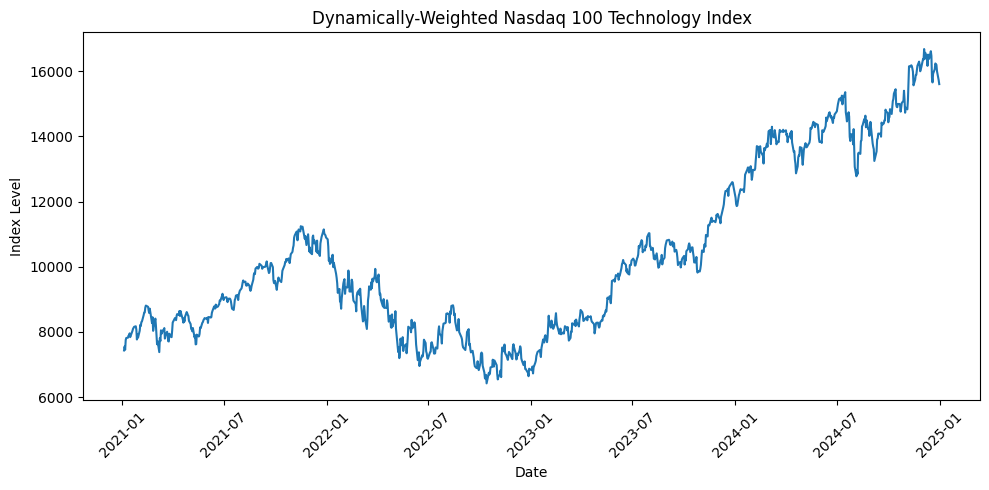

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your index data
index_returns = pd.read_csv('equal_weighted_index_without_arm.csv')
index_returns['Date'] = pd.to_datetime(index_returns['Date'])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(index_returns['Date'], index_returns['Index_Level'], label='Equal-Weighted Index')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.title('Dynamically-Weighted Nasdaq 100 Technology Index')
plt.tight_layout()

# Save the plot to file
plt.savefig('equal_weighted_index_plot.png', dpi=300)  # You can change the filename and resolution here

# Show the plot
plt.show()

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load the index data
index_level = pd.read_csv('equal_weighted_index_without_arm.csv')

# Convert 'Date' to datetime (optional but good practice)
index_level['Date'] = pd.to_datetime(index_level['Date'])

# Make sure 'Index_Return' is numeric and drop missing values
index_level['Index_Level'] = pd.to_numeric(index_level['Index_Level'], errors='coerce')
index_level = index_level.dropna(subset=['Index_Level'])

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(index_level['Index_Level'])

# Print the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Check stationarity
if adf_result[1] < 0.05:
    print("The series is stationary (reject null hypothesis).")
else:
    print("The series is non-stationary (fail to reject null hypothesis).")


ADF Statistic: -0.4713446690151948
p-value: 0.8974881341722136
Critical Values:
   1%: -3.436879978012783
   5%: -2.86442302475405
   10%: -2.568305057578451
The series is non-stationary (fail to reject null hypothesis).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the index data
index_returns = pd.read_csv('equal_weighted_index_without_arm.csv')

# Convert 'Date' to datetime (optional)
index_returns['Date'] = pd.to_datetime(index_returns['Date'])

# Ensure 'Index_Return' is numeric and clean
index_returns['Index_Return'] = pd.to_numeric(index_returns['Index_Return'], errors='coerce')
index_returns = index_returns.dropna(subset=['Index_Return'])

# ACF Plot
plt.figure(figsize=(8, 5))
plot_acf(index_returns['Index_Return'], lags=30)
plt.title('ACF of Index Returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.savefig('acf_index_returns.png', dpi=300)
plt.close()

# PACF Plot
plt.figure(figsize=(8, 5))
plot_pacf(index_returns['Index_Return'], lags=30, method='ywm')
plt.title('PACF of Index Returns')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.savefig('pacf_index_returns.png', dpi=300)
plt.close()

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [ ]:
#new plots for index price not returns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the index data
index_level = pd.read_csv('equal_weighted_index_without_arm.csv')

# Convert 'Date' to datetime (optional)
index_level['Date'] = pd.to_datetime(index_level['Date'])

# Ensure 'Index_Return' is numeric and clean
index_level['Index_Level'] = pd.to_numeric(index_level['Index_Level'], errors='coerce')
index_level = index_level.dropna(subset=['Index_Level'])

# ACF Plot
plt.figure(figsize=(8, 5))
plot_acf(index_level['Index_Level'], lags=100)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.savefig('acf_index_level.png', dpi=300)
plt.close()

# PACF Plot
plt.figure(figsize=(8, 5))
plot_pacf(index_level['Index_Level'], lags=100, method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.savefig('pacf_index_level.png', dpi=300)
plt.close()

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

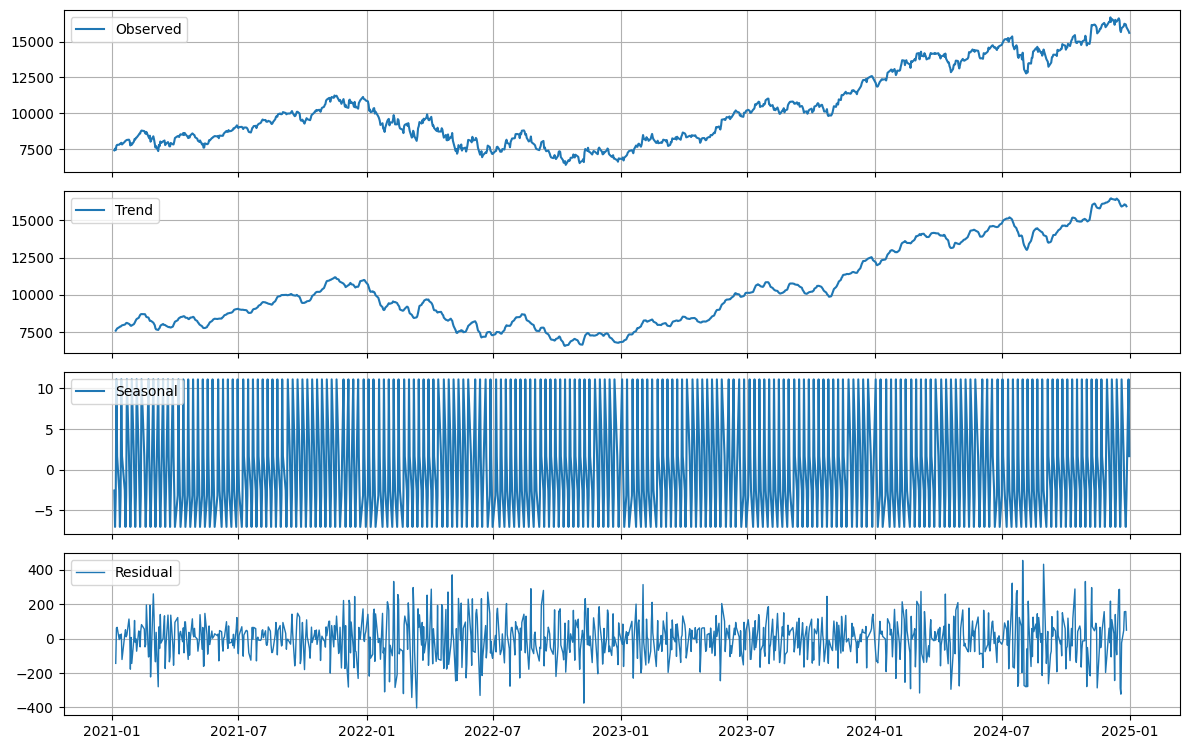

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# === Load and prepare the data ===
df = pd.read_csv("equal_weighted_index_without_arm.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.asfreq('B')  # Business-day frequency (trading days)

# Drop missing index levels
df['Index_Level'] = pd.to_numeric(df['Index_Level'], errors='coerce')
df.dropna(subset=['Index_Level'], inplace=True)

# === Decomposition ===
result = seasonal_decompose(df['Index_Level'], model='additive', period=5)

# === Custom plot with line for residuals ===
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axes[0].plot(result.observed, label='Observed')
axes[0].legend(loc='upper left')

axes[1].plot(result.trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(result.seasonal, label='Seasonal')
axes[2].legend(loc='upper left')

axes[3].plot(result.resid, label='Residual', linewidth=1)
axes[3].legend(loc='upper left')

for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig("index_decomposition_line_residual.png", dpi=300)
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

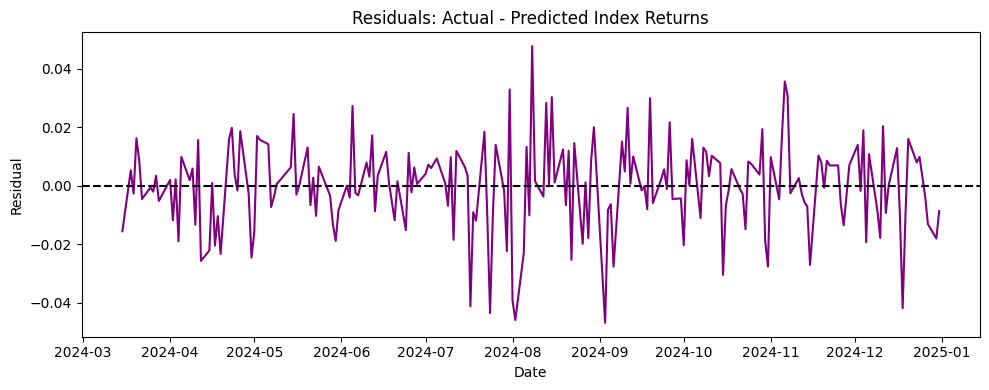

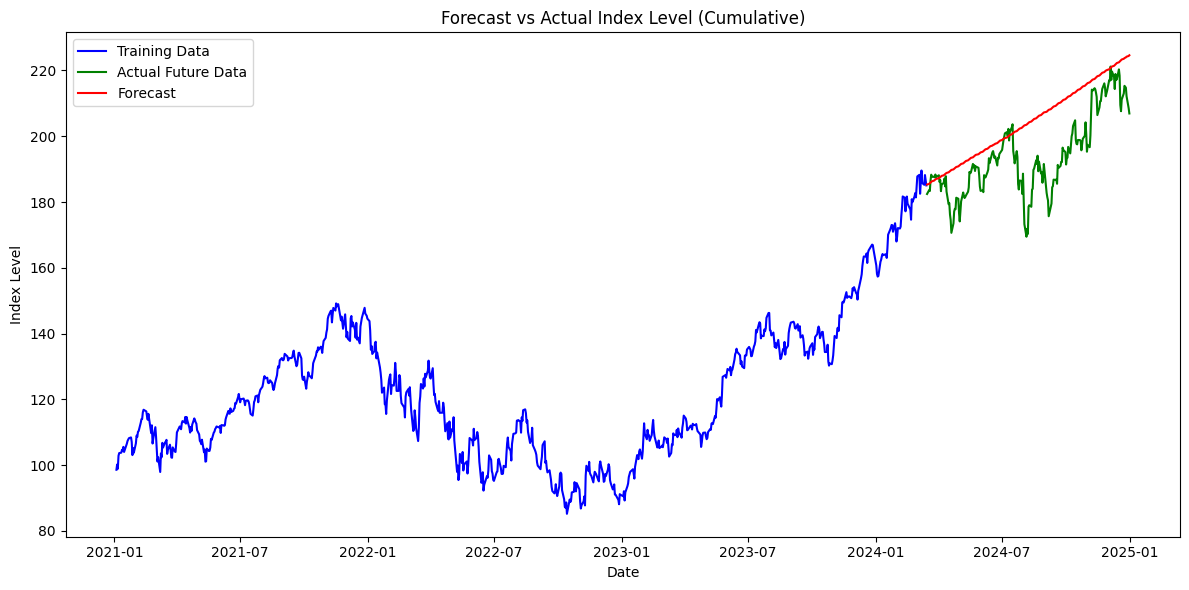

RMSE: 0.0153


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load datasets
df = pd.read_csv("cleaned_stock_data_without_arm.csv")
index_df = pd.read_csv("equal_weighted_index_without_arm.csv")

# Prepare columns
df['Date'] = pd.to_datetime(df['Date'])
index_df['Date'] = pd.to_datetime(index_df['Date'])
df['Return'] = pd.to_numeric(df['Return'], errors='coerce')
df = df.dropna(subset=['Return'])

# Global train-test split using index dates
split_idx = int(len(index_df) * 0.8)
train_dates = index_df['Date'][:split_idx]
test_dates = index_df['Date'][split_idx:]

# Forecast per company
predictions = []

for company in df['Company'].unique():
    company_data = df[df['Company'] == company]

    train_data = company_data[company_data['Date'].isin(train_dates)].copy()
    test_data = company_data[company_data['Date'].isin(test_dates)].copy()

    if len(train_data) > 20 and len(test_data) > 0:
        try:
            # Set index (no frequency assumptions)
            train_data.set_index('Date', inplace=True)
            test_data.set_index('Date', inplace=True)

            model = ARIMA(train_data['Return'], order=(1, 0, 1))
            model_fit = model.fit()

            forecast = model_fit.get_forecast(steps=len(test_data))
            preds = forecast.predicted_mean

            temp = pd.DataFrame({
                'Date': test_data.index,
                'Company': company,
                'Predicted_Return': preds.values
            })
            predictions.append(temp)

        except Exception as e:
            print(f"Skipped {company}: {e}")
            continue

# Combine predictions
pred_df = pd.concat(predictions)

# Equal-weighted predicted index returns
index_pred = pred_df.groupby('Date')['Predicted_Return'].mean().reset_index()

# Merge with actual index returns
actual_test = index_df[index_df['Date'].isin(test_dates)]
merged = pd.merge(actual_test, index_pred, on='Date', how='inner')
merged['Residual'] = merged['Index_Return'] - merged['Predicted_Return']

# Save residuals plot
plt.figure(figsize=(10, 4))
plt.plot(merged['Date'], merged['Residual'], color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title("Residuals: Actual - Predicted Index Returns")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.tight_layout()
plt.savefig("residuals_plot.png", dpi=300)
plt.show()

# Prepare cumulative returns for training and test
train_index = index_df[index_df['Date'].isin(train_dates)].copy()
test_index = merged.copy()

train_index['Cumulative'] = (1 + train_index['Index_Return']).cumprod() * 100  # base 100
test_index['Actual_Cumulative'] = (1 + test_index['Index_Return']).cumprod() * train_index['Cumulative'].iloc[-1]
test_index['Forecast_Cumulative'] = (1 + test_index['Predicted_Return']).cumprod() * train_index['Cumulative'].iloc[-1]


# Plot like the example
plt.figure(figsize=(12, 6))
plt.plot(train_index['Date'], train_index['Cumulative'], label='Training Data', color='blue')
plt.plot(test_index['Date'], test_index['Actual_Cumulative'], label='Actual Future Data', color='green')
plt.plot(test_index['Date'], test_index['Forecast_Cumulative'], label='Forecast', color='red')
plt.title("Forecast vs Actual Index Level (Cumulative)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.tight_layout()
plt.savefig("forecast_vs_actual_with_confidence.png", dpi=300)
plt.show()


# RMSE
rmse = np.sqrt(mean_squared_error(merged['Index_Return'], merged['Predicted_Return']))
print(f"RMSE: {rmse:.4f}")


In [ ]:
# Save merged actual vs predicted index returns
merged.to_csv("predicted_vs_actual_index_returns.csv", index=False)

Index(['Date', 'Company', 'Price Close', 'Volume', 'Return', 'Mkt-RF', 'SMB',
       'HML', 'RMW', 'CMA', 'RF'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

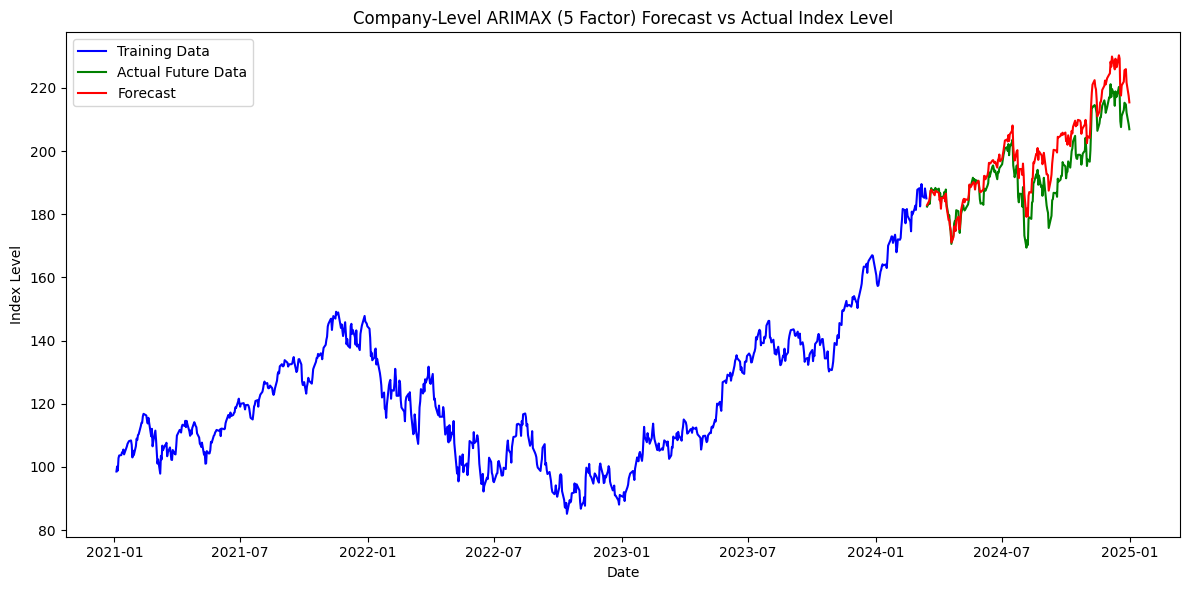

Company-level ARIMAX (5 Factor) RMSE: 0.0063


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# === STEP 1: Load your actual company data ===
df = pd.read_csv("cleaned_stock_data_without_arm.csv")
index_df = pd.read_csv("equal_weighted_index_without_arm.csv")

# === STEP 2: Prepare the data ===
df['Date'] = pd.to_datetime(df['Date'])
index_df['Date'] = pd.to_datetime(index_df['Date'])

# Check column names
print(df.columns)

# Ensure numeric and clean
df['Return'] = pd.to_numeric(df['Return'], errors='coerce')
df = df.dropna(subset=['Return', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])

# === STEP 3: Global train-test split ===
split_idx = int(len(index_df) * 0.8)
train_dates = index_df['Date'][:split_idx]
test_dates = index_df['Date'][split_idx:]

# === STEP 4: Loop over companies and apply ARIMAX (with 5 factors) ===
predictions = []

for company in df['Company'].unique():
    company_data = df[df['Company'] == company]

    train_data = company_data[company_data['Date'].isin(train_dates)].copy()
    test_data = company_data[company_data['Date'].isin(test_dates)].copy()

    if len(train_data) > 20 and len(test_data) > 0:
        try:
            train_data.set_index('Date', inplace=True)
            test_data.set_index('Date', inplace=True)

            endog_train = train_data['Return']
            exog_train = train_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
            exog_test = test_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

            model = SARIMAX(endog_train, exog=exog_train, order=(1, 0, 1))
            model_fit = model.fit(disp=False)

            forecast = model_fit.get_forecast(steps=len(test_data), exog=exog_test)
            preds = forecast.predicted_mean

            temp = pd.DataFrame({
                'Date': test_data.index,
                'Company': company,
                'Predicted_Return': preds.values
            })
            predictions.append(temp)

        except Exception as e:
            print(f"Skipped {company}: {e}")
            continue

# === STEP 5: Combine per-company forecasts ===
pred_df = pd.concat(predictions)

# Save per-company predictions
pred_df.to_csv("company_level_arimax_predictions_5factor.csv", index=False)

# === STEP 6: Aggregate per date (equal-weighted index) ===
index_pred = pred_df.groupby('Date')['Predicted_Return'].mean().reset_index()

# Merge with actual index returns
actual_test = index_df[index_df['Date'].isin(test_dates)]
merged = pd.merge(actual_test, index_pred, on='Date', how='inner')
merged['Residual'] = merged['Index_Return'] - merged['Predicted_Return']

# Save index-level predictions
merged.to_csv("index_level_arimax_predicted_vs_actual_5factor.csv", index=False)

# === STEP 7: Plot cumulative returns ===
train_index = index_df[index_df['Date'].isin(train_dates)].copy()
train_index['Cumulative'] = (1 + train_index['Index_Return']).cumprod() * 100

merged['Actual_Cumulative'] = (1 + merged['Index_Return']).cumprod() * train_index['Cumulative'].iloc[-1]
merged['Forecast_Cumulative'] = (1 + merged['Predicted_Return']).cumprod() * train_index['Cumulative'].iloc[-1]

plt.figure(figsize=(12, 6))
plt.plot(train_index['Date'], train_index['Cumulative'], label='Training Data', color='blue')
plt.plot(merged['Date'], merged['Actual_Cumulative'], label='Testing Data', color='green')
plt.plot(merged['Date'], merged['Forecast_Cumulative'], label='Forecast', color='red')
plt.title("Company-Level ARIMAX (5 Factor) Forecast vs Actual Index Level")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.tight_layout()
plt.savefig("company_arimax_5factor_forecast_vs_actual.png", dpi=300)
plt.show()

# === STEP 8: RMSE ===
rmse = np.sqrt(mean_squared_error(merged['Index_Return'], merged['Predicted_Return']))
print(f"Company-level ARIMAX (5 Factor) RMSE: {rmse:.4f}")


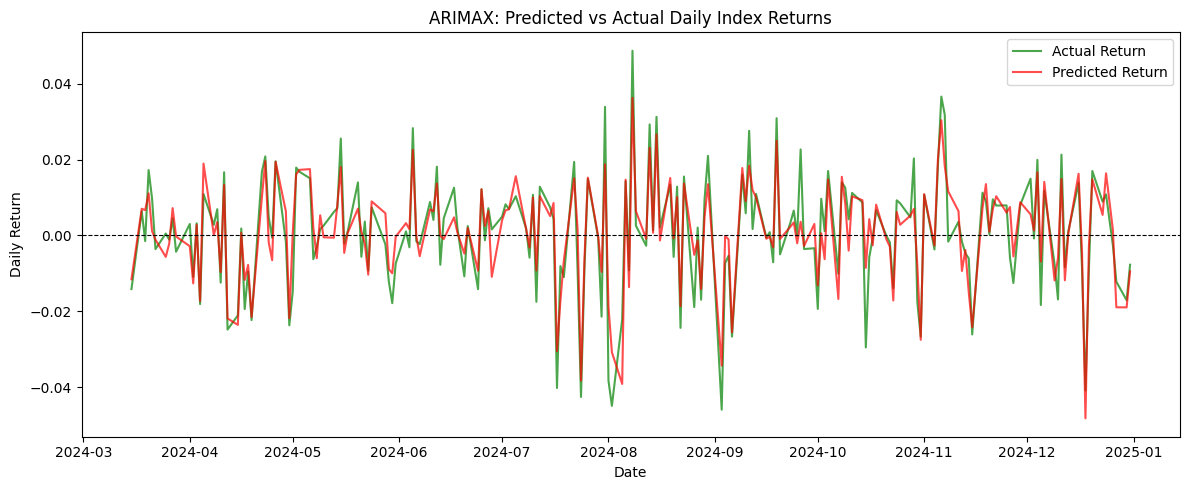

In [ ]:
import matplotlib.pyplot as plt

# This assumes your merged DataFrame already includes:
# - Date
# - Index_Return
# - Predicted_Return
# - Residual

plt.figure(figsize=(12, 5))
plt.plot(merged['Date'], merged['Index_Return'], label='Actual Return', color='green', alpha=0.7)
plt.plot(merged['Date'], merged['Predicted_Return'], label='Predicted Return', color='red', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("ARIMAX: Predicted vs Actual Daily Index Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.tight_layout()
plt.savefig("arimax_predicted_vs_actual_returns.png", dpi=300)
plt.show()


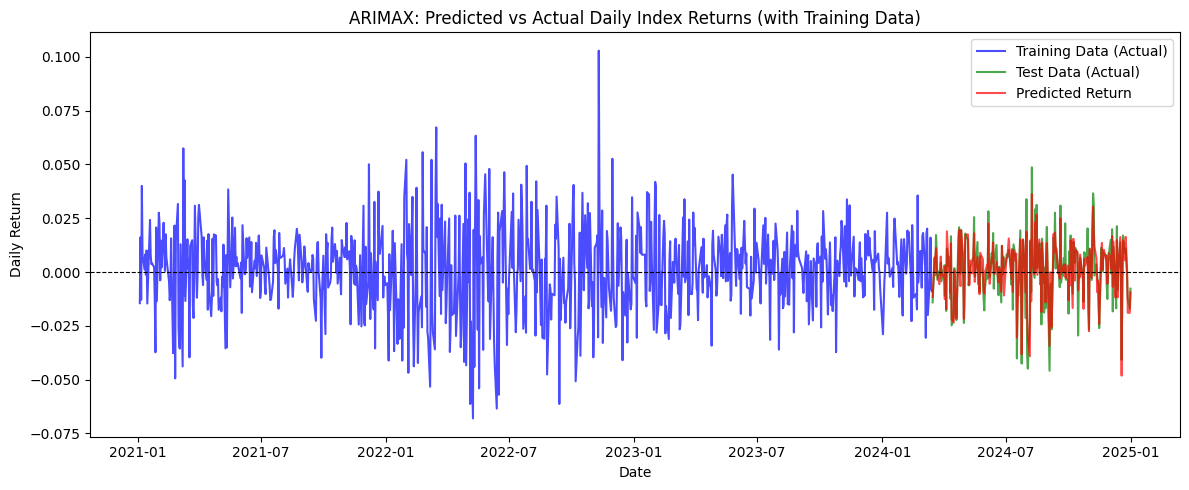

In [ ]:
import matplotlib.pyplot as plt

# Training data (actual returns only)
train_index = index_df[index_df['Date'].isin(train_dates)].copy()

plt.figure(figsize=(12, 5))

# Plot training data
plt.plot(train_index['Date'], train_index['Index_Return'], label='Training Data (Actual)', color='blue', alpha=0.7)

# Plot test actual returns
plt.plot(merged['Date'], merged['Index_Return'], label='Test Data (Actual)', color='green', alpha=0.7)

# Plot predicted returns
plt.plot(merged['Date'], merged['Predicted_Return'], label='Predicted Return', color='red', alpha=0.7)

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("ARIMAX: Predicted vs Actual Daily Index Returns (with Training Data)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.tight_layout()
plt.savefig("arimax_returns_with_training.png", dpi=300)
plt.show()


Index(['Date', 'Company', 'Price Close', 'Volume', 'Return', 'Mkt-RF', 'SMB',
       'HML', 'RMW', 'CMA', 'RF'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

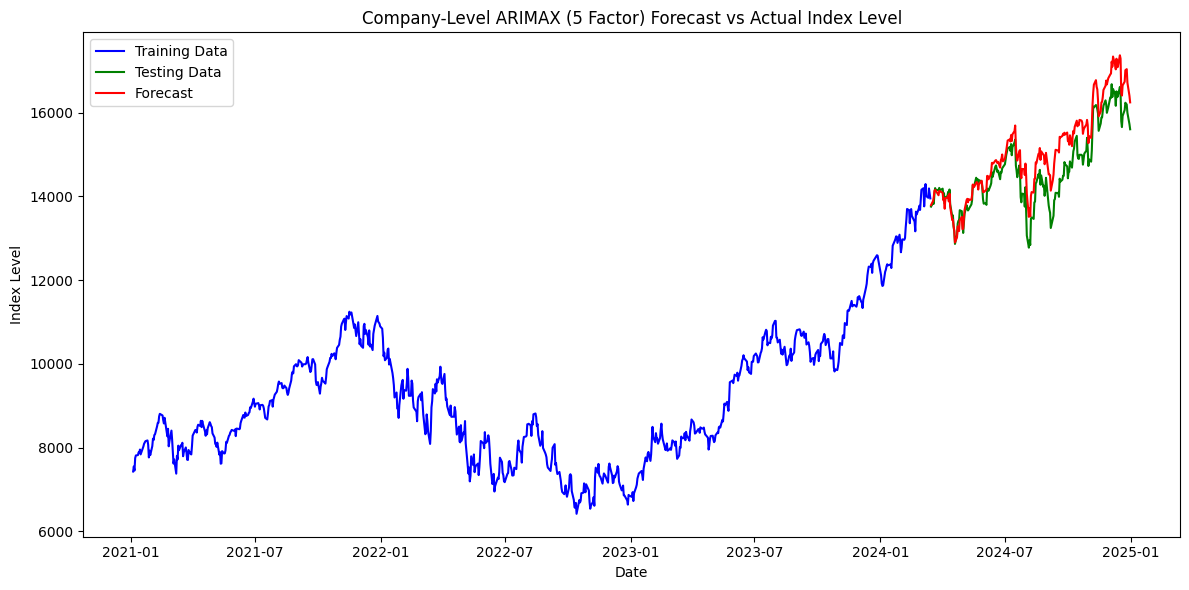

Company-level ARIMAX (5 Factor) RMSE: 0.0063


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# === STEP 1: Load your actual company data ===
df = pd.read_csv("cleaned_stock_data_without_arm.csv")
index_df = pd.read_csv("equal_weighted_index_without_arm.csv")

# === STEP 2: Prepare the data ===
df['Date'] = pd.to_datetime(df['Date'])
index_df['Date'] = pd.to_datetime(index_df['Date'])

# Check column names
print(df.columns)

# Ensure numeric and clean
df['Return'] = pd.to_numeric(df['Return'], errors='coerce')
df = df.dropna(subset=['Return', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])

# === STEP 3: Global train-test split ===
split_idx = int(len(index_df) * 0.8)
train_dates = index_df['Date'][:split_idx]
test_dates = index_df['Date'][split_idx:]

# === STEP 4: Loop over companies and apply ARIMAX (with 5 factors) ===
predictions = []

for company in df['Company'].unique():
    company_data = df[df['Company'] == company]

    train_data = company_data[company_data['Date'].isin(train_dates)].copy()
    test_data = company_data[company_data['Date'].isin(test_dates)].copy()

    if len(train_data) > 20 and len(test_data) > 0:
        try:
            train_data.set_index('Date', inplace=True)
            test_data.set_index('Date', inplace=True)

            endog_train = train_data['Return']
            exog_train = train_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
            exog_test = test_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

            model = SARIMAX(endog_train, exog=exog_train, order=(1, 0, 1))
            model_fit = model.fit(disp=False)

            forecast = model_fit.get_forecast(steps=len(test_data), exog=exog_test)
            preds = forecast.predicted_mean

            temp = pd.DataFrame({
                'Date': test_data.index,
                'Company': company,
                'Predicted_Return': preds.values
            })
            predictions.append(temp)

        except Exception as e:
            print(f"Skipped {company}: {e}")
            continue

# === STEP 5: Combine per-company forecasts ===
pred_df = pd.concat(predictions)

# Save per-company predictions
pred_df.to_csv("company_level_arimax_predictions_5factor.csv", index=False)

# === STEP 6: Aggregate per date (equal-weighted index) ===
index_pred = pred_df.groupby('Date')['Predicted_Return'].mean().reset_index()

# Merge with actual index returns
actual_test = index_df[index_df['Date'].isin(test_dates)]
merged = pd.merge(actual_test, index_pred, on='Date', how='inner')
merged['Residual'] = merged['Index_Return'] - merged['Predicted_Return']

# Save index-level predictions
merged.to_csv("index_level_arimax_predicted_vs_actual_5factor.csv", index=False)

# === STEP 7: Plot cumulative returns ===
train_index = index_df[index_df['Date'].isin(train_dates)].copy()
starting_value = 7541.05

train_index['Cumulative'] = (1 + train_index['Index_Return']).cumprod() * starting_value

merged['Actual_Cumulative'] = (1 + merged['Index_Return']).cumprod() * train_index['Cumulative'].iloc[-1]
merged['Forecast_Cumulative'] = (1 + merged['Predicted_Return']).cumprod() * train_index['Cumulative'].iloc[-1]

plt.figure(figsize=(12, 6))
plt.plot(train_index['Date'], train_index['Cumulative'], label='Training Data', color='blue')
plt.plot(merged['Date'], merged['Actual_Cumulative'], label='Testing Data', color='green')
plt.plot(merged['Date'], merged['Forecast_Cumulative'], label='Forecast', color='red')
plt.title("Company-Level ARIMAX (5 Factor) Forecast vs Actual Index Level")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.tight_layout()
plt.savefig("company_arimax_5factor_forecast_vs_actual.png", dpi=300)
plt.show()

# === STEP 8: RMSE ===
rmse = np.sqrt(mean_squared_error(merged['Index_Return'], merged['Predicted_Return']))
print(f"Company-level ARIMAX (5 Factor) RMSE: {rmse:.4f}")


In [ ]:
pip install pmdarima

In [ ]:
import pandas as pd

# Load index return data
index_df = pd.read_csv('equal_weighted_index_without_arm.csv')

# Preprocess to match the structure from your reference
dataset_ex_df = index_df.copy()
dataset_ex_df = dataset_ex_df.reset_index(drop=True)
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)
dataset_ex_df = dataset_ex_df[['Index_Return']]  # keep only the return column

# Check the structure
print(dataset_ex_df.head())



            Index_Return
Date                    
2021-01-04     -0.014469
2021-01-05      0.016157
2021-01-06     -0.012898
2021-01-07      0.040033
2021-01-08      0.007962


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

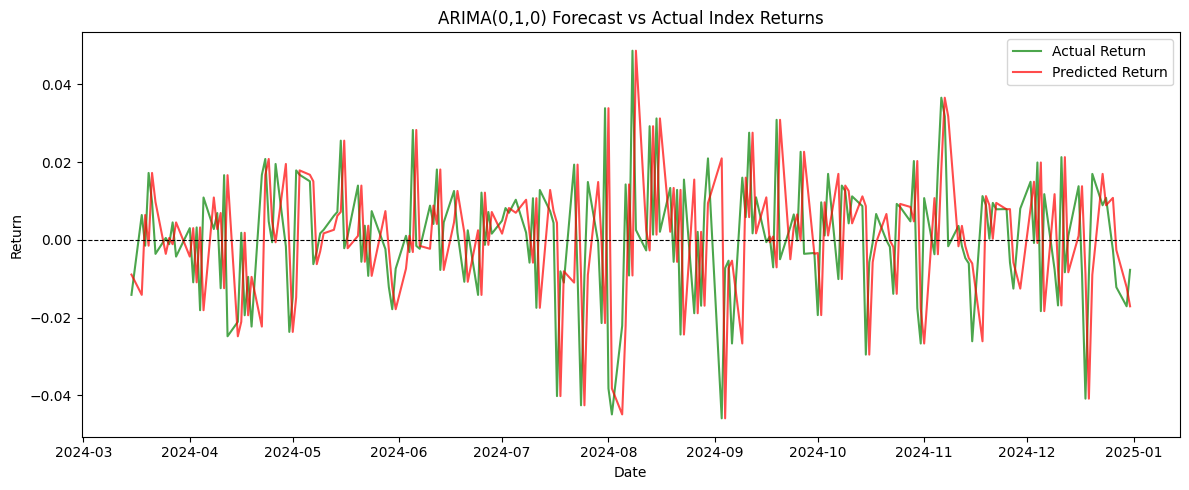

ARIMA(0,1,0) Index Return RMSE: 2.1571%


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# === Load and preprocess your index data ===
df = pd.read_csv("equal_weighted_index_without_arm.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['Index_Return'])
df = df.sort_values('Date')
dataset_ex_df = df.set_index('Date')[['Index_Return']]  # match structure

# === Define ARIMA(0,1,0) forecast function ===
def arima_forecast(history):
    model = ARIMA(history, order=(0, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# === Split into train/test ===
X = dataset_ex_df['Index_Return'].values
size = int(len(X) * 0.8)
train, test = X[:size], X[size:]

# === Walk-forward validation ===
history = list(train)
predictions = []
for t in range(len(test)):
    yhat = arima_forecast(history)
    predictions.append(yhat)
    history.append(test[t])

# === Create date range for test set ===
test_dates = dataset_ex_df.index[size:]
predicted_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': test,
    'Predicted': predictions
})

# === Save predictions to CSV ===
predicted_df.to_csv("arima_index_return_predictions.csv", index=False)

# === Plot actual vs predicted returns ===
plt.figure(figsize=(12, 5))
plt.plot(predicted_df['Date'], predicted_df['Actual'], label='Actual Return', color='green', alpha=0.7)
plt.plot(predicted_df['Date'], predicted_df['Predicted'], label='Predicted Return', color='red', alpha=0.7)
plt.axhline(0, linestyle='--', color='black', linewidth=0.8)
plt.title("ARIMA(0,1,0) Forecast vs Actual Index Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.savefig("arima_010_index_return_plot.png", dpi=300)
plt.show()

# === Calculate RMSE ===
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"ARIMA(0,1,0) Index Return RMSE: {rmse:.4%}")


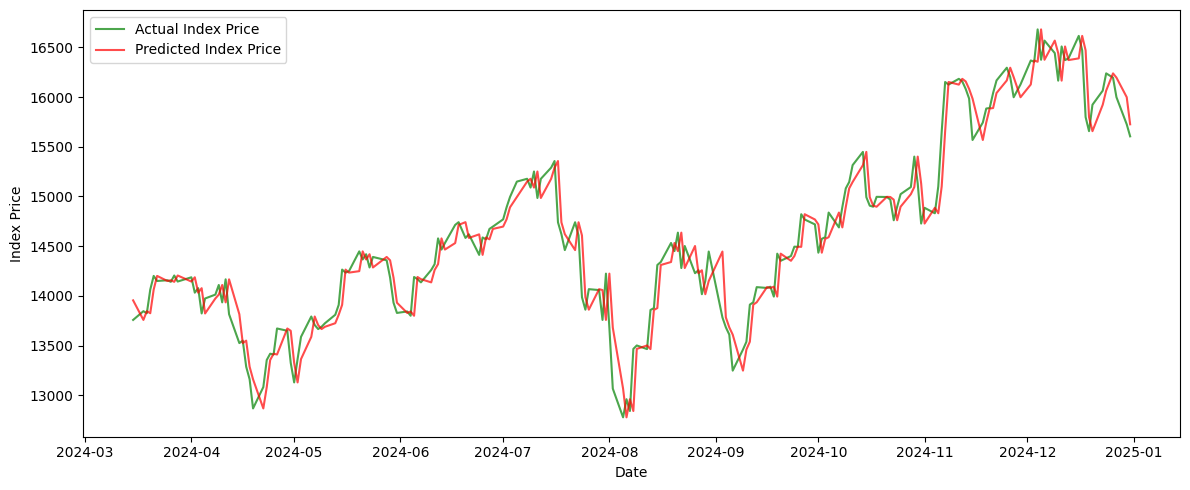

ARIMA(0,1,0) Index Level RMSE: 221.73


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# === Load and preprocess your index data (use prices) ===
df = pd.read_csv("equal_weighted_index_without_arm.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['Index_Level'])  # now using prices
df = df.sort_values('Date')
dataset_ex_df = df.set_index('Date')[['Index_Level']]

# === Define ARIMA(2,1,2) forecast function ===
def arima_forecast(history):
    model = ARIMA(history, order=(0, 1, 0))  # use the optimal order
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# === Split into train/test ===
X = dataset_ex_df['Index_Level'].values
size = int(len(X) * 0.8)
train, test = X[:size], X[size:]

# === Walk-forward validation ===
history = list(train)
predictions = []
for t in range(len(test)):
    yhat = arima_forecast(history)
    predictions.append(yhat)
    history.append(test[t])

# === Create date range for test set ===
test_dates = dataset_ex_df.index[size:]
predicted_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': test,
    'Predicted': predictions
})

# === Save predictions to CSV ===
predicted_df.to_csv("arima_index_price_predictions.csv", index=False)

# === Plot actual vs predicted prices ===
plt.figure(figsize=(12, 5))
plt.plot(predicted_df['Date'], predicted_df['Actual'], label='Actual Index Price', color='green', alpha=0.7)
plt.plot(predicted_df['Date'], predicted_df['Predicted'], label='Predicted Index Price', color='red', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Index Price")
plt.legend()
plt.tight_layout()
plt.savefig("arima_010_index_level_plot.png", dpi=300)
plt.show()

# === Calculate RMSE ===
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"ARIMA(0,1,0) Index Level RMSE: {rmse:.2f}")


Validation RMSE (ARIMA(0,1,0)): 161.05


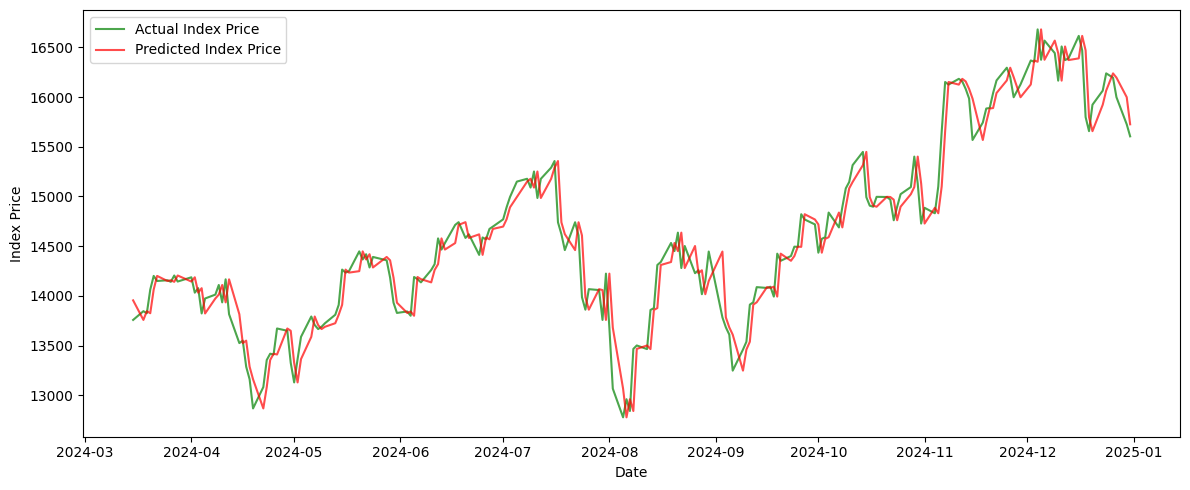

Test RMSE (ARIMA(0,1,0)): 221.73


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# === Load and preprocess your index data (use prices) ===
df = pd.read_csv("equal_weighted_index_without_arm.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['Index_Level'])
df = df.sort_values('Date')
dataset_ex_df = df.set_index('Date')[['Index_Level']]

# === Define ARIMA forecast function ===
def arima_forecast(history, order=(0, 1, 0)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    return output[0]

# === Split into train/validation/test ===
X = dataset_ex_df['Index_Level'].values
n = len(X)
train_size = int(n * 0.6)
val_size = int(n * 0.2)
test_size = n - train_size - val_size

train = X[:train_size]
val = X[train_size:train_size + val_size]
test = X[train_size + val_size:]

# === Walk-forward validation for validation set ===
history_val = list(train)
val_predictions = []
for t in range(len(val)):
    yhat = arima_forecast(history_val)
    val_predictions.append(yhat)
    history_val.append(val[t])

val_rmse = np.sqrt(mean_squared_error(val, val_predictions))
print(f"Validation RMSE (ARIMA(0,1,0)): {val_rmse:.2f}")

# === Walk-forward validation for test set ===
history_test = list(train) + list(val)
test_predictions = []
for t in range(len(test)):
    yhat = arima_forecast(history_test)
    test_predictions.append(yhat)
    history_test.append(test[t])

test_dates = dataset_ex_df.index[train_size + val_size:]
predicted_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': test,
    'Predicted': test_predictions
})

# === Save and plot test predictions ===
predicted_df.to_csv("arima_index_price_predictions_test.csv", index=False)

plt.figure(figsize=(12, 5))
plt.plot(predicted_df['Date'], predicted_df['Actual'], label='Actual Index Price', color='green', alpha=0.7)
plt.plot(predicted_df['Date'], predicted_df['Predicted'], label='Predicted Index Price', color='red', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Index Price")
plt.legend()
plt.tight_layout()
plt.savefig("arima_index_level_plot_test.png", dpi=300)
plt.show()

# === Final RMSE ===
test_rmse = np.sqrt(mean_squared_error(test, test_predictions))
print(f"Test RMSE (ARIMA(0,1,0)): {test_rmse:.2f}")


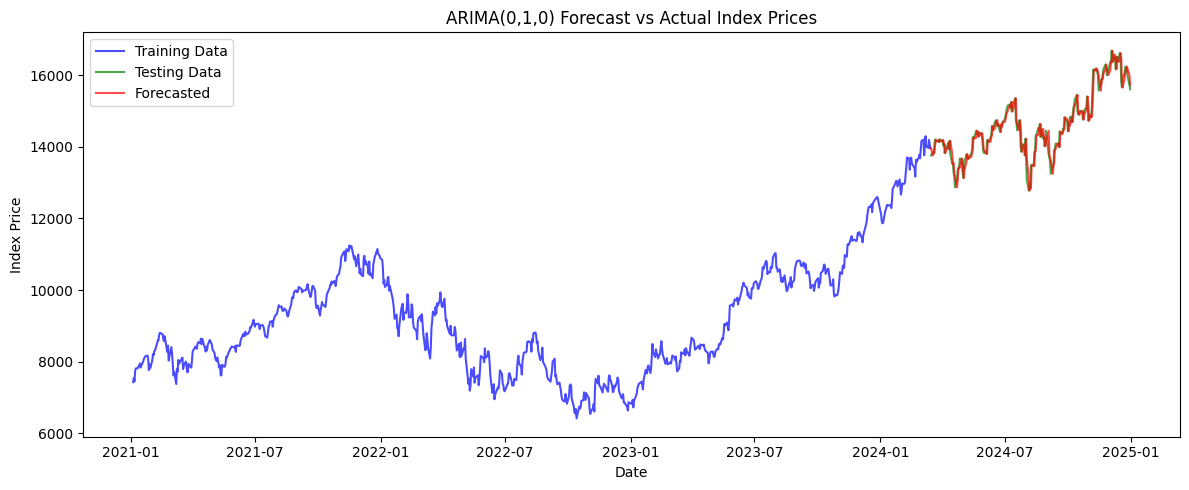

ARIMA(0,1,0) Index Level RMSE: 221.73


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# === Load and preprocess your index data (use prices) ===
df = pd.read_csv("equal_weighted_index_without_arm.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['Index_Level'])  # use prices
df = df.sort_values('Date')
dataset_ex_df = df.set_index('Date')[['Index_Level']]

# === Define ARIMA(0,1,0) forecast function ===
def arima_forecast(history):
    model = ARIMA(history, order=(0, 1, 0))  # you had (0,1,0) in your title
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# === Split into train/test ===
X = dataset_ex_df['Index_Level'].values
dates = dataset_ex_df.index
size = int(len(X) * 0.8)
train, test = X[:size], X[size:]
train_dates, test_dates = dates[:size], dates[size:]

# === Walk-forward validation ===
history = list(train)
predictions = []
for t in range(len(test)):
    yhat = arima_forecast(history)
    predictions.append(yhat)
    history.append(test[t])

# === Create DataFrame for test set ===
predicted_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': test,
    'Predicted': predictions
})

# === Save predictions to CSV ===
predicted_df.to_csv("arima_index_price_predictions.csv", index=False)

# === Plot training, actual, and predicted prices ===
plt.figure(figsize=(12, 5))

# Plot training data
plt.plot(train_dates, train, label='Training Data', color='blue', alpha=0.7)

# Plot actual future data
plt.plot(predicted_df['Date'], predicted_df['Actual'], label='Testing Data', color='green', alpha=0.7)

# Plot predicted future data
plt.plot(predicted_df['Date'], predicted_df['Predicted'], label='Forecasted', color='red', alpha=0.7)

plt.title("ARIMA(0,1,0) Forecast vs Actual Index Prices")
plt.xlabel("Date")
plt.ylabel("Index Price")
plt.legend()
plt.tight_layout()
plt.savefig("arima_010_index_level_with_training_plot.png", dpi=300)
plt.show()

# === Calculate RMSE ===
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"ARIMA(0,1,0) Index Level RMSE: {rmse:.2f}")


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (example: ARIMA(0,1,0))
model = ARIMA(train, order=(0, 1, 0))
model_fit = model.fit()
residuals = model_fit.resid


<Figure size 1000x400 with 0 Axes>

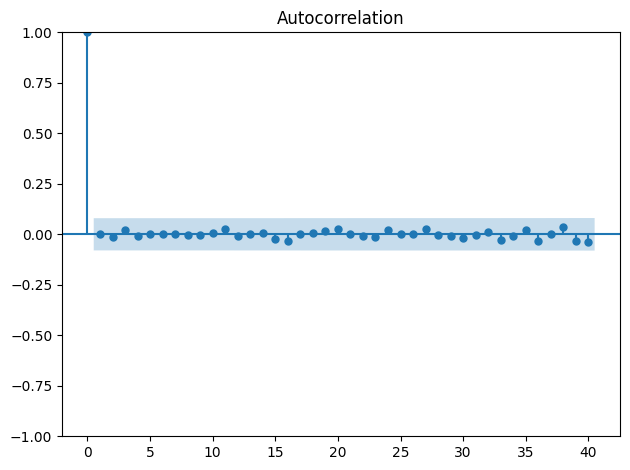

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=40)
plt.tight_layout()
plt.savefig("ACF_of_Residuals.png", dpi=300)
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test up to lag 20
ljung_box = acorr_ljungbox(residuals, lags=[20], return_df=True)
print(ljung_box)


    lb_stat  lb_pvalue
20  4.28236   0.999919
